In [1]:
# load data
from pathlib import Path
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

fn = 'data/newsroom/newsroom_dev.snappy.parquet'

df = pd.read_parquet(path=str(fn), engine='pyarrow', columns=['text', 'summary'])
df.head()


,text,summary
0,"Van Cliburn, a little-known pianist who in 195...","Van Cliburn, a little-known pianist who in 195..."
1,Republicans need to be very careful about how ...,Ed Rollins puts his party on notice.
2,It is hard to believe in the cold light of day...,"Watching a car go round in circles, chasing a ..."
3,Over 100 dancers and musicians bring Nutcracke...,Get information and buy cheap theatre tickets ...
4,The Federal Reserve will shed more light this ...,The Federal Reserve will shed more light this ...


In [2]:
# count bad entries
text_lens = df['text'].map(lambda x: len(x.strip()))
summary_lens = df['summary'].map(lambda x: len(x.strip()))

print('# empty texts:',(text_lens == 0).sum())
print('# empty summaries:', (summary_lens == 0).sum())
print('# len(summary) > len(text):', (summary_lens > text_lens).values.sum())



# empty texts: 224
# empty summaries: 0
# len(summary) > len(text): 525


In [4]:
# load contriever
cache_dir = '../hf_model_cache'
tokenizer = AutoTokenizer.from_pretrained('facebook/contriever', cache_dir=cache_dir)
model = AutoModel.from_pretrained('facebook/contriever', cache_dir=cache_dir)

device = torch.device('cuda', 0)
model.to(device)

# Mean pooling
def mean_pooling(token_embeddings, mask):
    token_embeddings = token_embeddings.masked_fill(~mask[..., None].bool(), 0.)
    sentence_embeddings = token_embeddings.sum(dim=1) / mask.sum(dim=1)[..., None]
    return sentence_embeddings


In [27]:
sentences = [
    "Where was Marie Curie born?",
    "Maria Sklodowska, later known as Marie Curie, was born on November 7, 1867.",
    "Born in Paris on 15 May 1859, Pierre Curie was the son of Eugène Curie, a doctor of French Catholic origin from Alsace."
]

# Apply tokenizer
inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
inputs.to(device)
# Compute token embeddings
outputs = model(**inputs)

# Mean pooling
def mean_pooling2(token_embeddings, mask):
    token_embeddings = token_embeddings.masked_fill(~mask[..., None].bool(), 0.)
    sentence_embeddings = token_embeddings.sum(dim=1) / mask.sum(dim=1)[..., None]
    print('token_embeddings', token_embeddings.shape)
    norms = token_embeddings.norm(dim=2)
    print(norms.shape)
    print(norms)
    return sentence_embeddings

embeddings = mean_pooling2(outputs[0], inputs['attention_mask'])

token_embeddings torch.Size([3, 30, 768])
torch.Size([3, 30])
tensor([[1.6140, 2.1100, 1.9741, 2.0378, 2.5250, 2.8620, 2.1630, 1.7535, 2.4752,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [1.9869, 2.4388, 3.0291, 4.7495, 3.0484, 2.8229, 2.6187, 2.2211, 2.0504,
         2.1424, 2.2558, 2.4842, 4.1084, 4.9285, 2.2359, 2.4623, 3.1264, 2.2984,
         3.7863, 2.9127, 2.2378, 2.1841, 2.2298, 1.7392, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [1.7617, 2.3520, 2.2223, 2.3895, 1.5948, 1.9639, 2.2966, 2.3925, 2.2207,
         3.2272, 5.0972, 5.2661, 2.4239, 2.2222, 2.3731, 2.2016, 1.7097, 3.1315,
         3.6246, 2.2361, 2.2329, 2.1508, 1.7370, 1.8898, 3.0919, 2.2448, 1.8859,
         2.9701, 2.2138, 1.6558]], device='cuda:0', grad_fn=<NormBackward1>)


In [5]:
# compute the cosine similariries between the contriever embeddings of text and summary of all entries
from typing import List
import numpy as np
from torch.nn.functional import cosine_similarity
from tqdm import tqdm


def embed(text_list: List[str], device: torch.DeviceObjType=None):
    tokens = tokenizer(text_list, padding=True, truncation=True, return_tensors='pt')
    if device is not None:
        tokens.to(device)
    outputs = model(**tokens)
    return mean_pooling(outputs[0], tokens['attention_mask'])


@torch.no_grad()
def compute_similarity_scores(texts: pd.Series, summaries: pd.Series, batch_size: int=64, device: torch.DeviceObjType=None):
    scores = []
    n = len(texts)
    assert n == len(summaries)
    for i in tqdm(range(0, n, batch_size)):
        text_list = texts.iloc[i:i+batch_size].to_list()
        summary_list = summaries.iloc[i:i+batch_size].to_list()

        a = embed(text_list, device)
        b = embed(summary_list, device)

        s = cosine_similarity(a, b)
        scores.append(s)

    return torch.cat(scores).cpu().numpy()

def token_counts(column, k=1000):
    token_counts = []
    n = len(column)
    for i in range(0, n, k):
        text = column.iloc[i:i+k].to_list()
        text_tokens = tokenizer(text, padding=False, truncation=False)
        token_counts.extend([len(x) for x in text_tokens['input_ids']])

    return token_counts

batch_size = 512

n = 25000
#n = len(df)

if n < len(df):
    sample_df = df.sample(n=n, random_state=4269, replace=False)
else:
    sample_df = df.copy()
scores = compute_similarity_scores(sample_df['text'], sample_df['summary'], batch_size=batch_size, device=device)
summary_token_counts = np.array(token_counts(sample_df['summary']))
text_token_counts = np.array(token_counts(sample_df['text']))



100%|██████████| 49/49 [05:31<00:00,  6.76s/it]
Token indices sequence length is longer than the specified maximum sequence length for this model (620 > 512). Running this sequence through the model will result in indexing errors


In [33]:


@torch.no_grad()
def compute_embeddings(texts: pd.Series, batch_size: int=64, device: torch.DeviceObjType=None):
    emb = []
    n = len(texts)
    for i in tqdm(range(0, n, batch_size)):
        text_list = texts.iloc[i:i+batch_size].to_list()
        e = embed(text_list, device)
        emb.append(e)

    return torch.cat(emb).cpu().numpy()

embeddings = compute_embeddings(sample_df['summary'], device=device)
print(embeddings.shape)




100%|██████████| 391/391 [01:07<00:00,  5.80it/s]


(25000, 768)


embeddings <class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Text(0, 0.5, 'embedding norm')

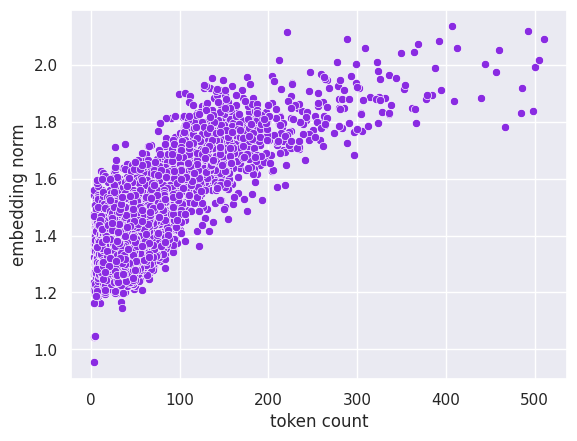

In [34]:
# plot token_counts vs contriever embedding norm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

norms = np.linalg.norm(embeddings, axis=1)
# remove summaries that exceed the contriever max input sequence length
x = summary_token_counts[summary_token_counts < 512]
y = norms[summary_token_counts < 512]
ax = sns.scatterplot(x=x, y=y, color="blueviolet")
ax.set_xlabel("token count")
ax.set_ylabel("embedding norm")

summary_token_counts(108599): min: 3; max: 1894; mean: 37.0045; meadian: 30.0;
text_token_counts(108599): min: 2; max: 38946; mean: 828.0113; meadian: 667.0;
scores(108599): min: 0.0744; max: 1.0000; mean: 0.4783; median: 0.4741;


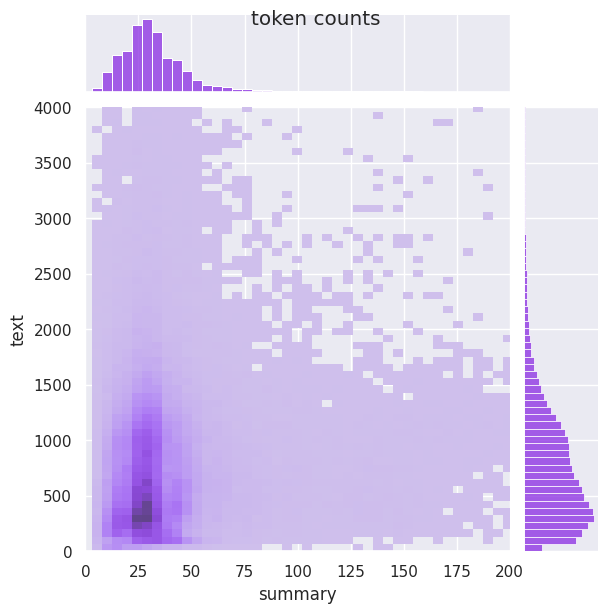

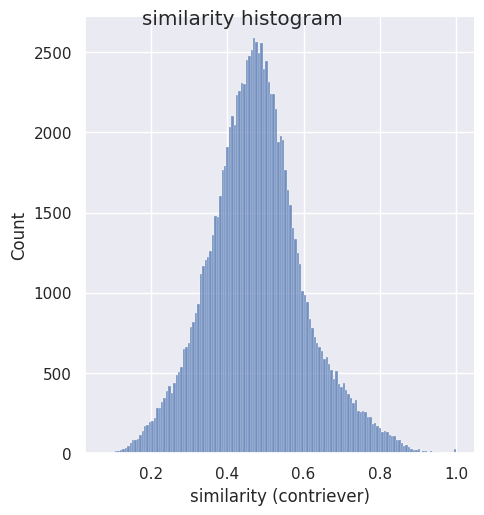

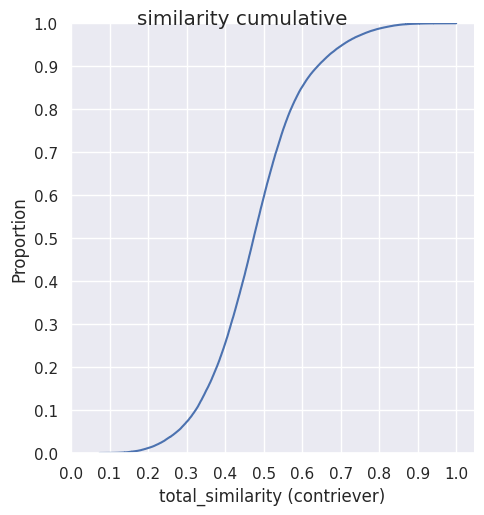

In [224]:
# plot similarity scores
import seaborn as sns
import matplotlib.pyplot as plt

def print_stats(x: np.ndarray, name: str):
    print(f'{name}({len(x)}): min: {x.min():.4f}; max: {x.max():.4f}; mean: {x.mean():.4f}; median: {np.median(x):.4f};')

def print_statsi(x: np.ndarray, name: str):
    print(f'{name}({len(x)}): min: {x.min()}; max: {x.max()}; mean: {x.mean():.4f}; meadian: {np.median(x)};')


sns.set_theme()

print_statsi(summary_token_counts, 'summary_token_counts')
print_statsi(text_token_counts, 'text_token_counts')
print_stats(scores, 'scores')

p = sns.jointplot(x=summary_token_counts, y=text_token_counts, kind="hist", color="blueviolet", xlim=(0,200), ylim=(0, 4000), bins=(400, 600)).set_axis_labels("summary", "text")
p.fig.suptitle('token counts')

p = sns.displot(data=scores, kind="hist", height=5).set(xlabel='similarity (contriever)')
p.fig.suptitle('similarity histogram')
p = sns.displot(data=scores, kind="ecdf", height=5).set(xlabel='total_similarity (contriever)', xticks=np.linspace(0,1,11), yticks=np.linspace(0,1,11))
p.fig.suptitle('similarity cumulative');


In [11]:
# search beginning of text in summary and determine how much text matches
import difflib

text = df['text']
summary = df['summary']

def summary_copy_ratio(text, summary):
    text = text[:1750]
    s = difflib.SequenceMatcher(None, text, summary, autojunk=False)
    blocks = s.get_matching_blocks()
    total_match = sum(b.size for b in blocks)
    return total_match / len(summary)

sample_df['overlap'] = sample_df.apply(lambda x: summary_copy_ratio(x['text'], x['summary']), axis=1)


entries with overlap > 0.95: 29.34%


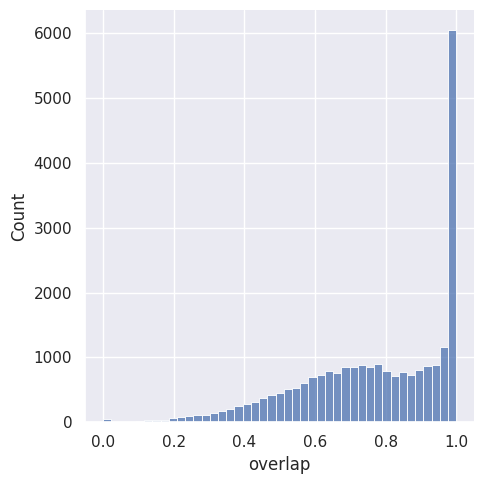

In [12]:
import seaborn as sns
sns.set_theme()

sns.displot(sample_df['overlap'])
hi_overlap = (sample_df['overlap'] > 0.95)
print(f'entries with overlap > 0.95: {hi_overlap.sum()/len(sample_df):.2%}')

In [13]:
# show some examples for different similiary score values
from IPython.display import Markdown, display

sample_df['score'] = scores
scored = sample_df.sort_values('score')

test_scores = np.linspace(0.1,0.9, 14)

output = []

for t in test_scores:
    scores_col = scored['score']  
    i = scores_col[scores_col.gt(t)].idxmin()
    entry = scored.loc[i]

    output.append('----')
    a,o,b,c = entry["score"].item(), entry['overlap'].item(), entry['text'], entry['summary']

    if len(b) > 1500:
        b = b[:1500] + f' (...) [{len(b)}]'

    if len(c) > 500:
        c = c[:500] + f' (...) [{len(c)}]'

    output.append(f'## [idx: {i}] score: {a:.4f} (overlap: {o:.2%})')
    output.append(f'```\n"{b}"\n```')
    output.append(f'## summary: {c}')

s = '\n'.join(output)

display(Markdown(s))


----
## [idx: 23275] score: 0.1071 (overlap: 80.00%)
```
"CAMDEN, Tenn., Oct 11 (Reuters) - If Tennessee Democrat Harold Ford loses his bid to become the first black senator from the U.S. South in more than 100 years, it won't be because he failed to court white, conservative voters.

While his opponent, Republican Bob Corker, charges in radio ads that Ford was "Tennessee's most liberal congressman" in his 10 years in the U.S. House of Representatives, Ford plays conservative themes.

"I'm the only one in this race who has voted for a strong anti-illegal-immigration bill. I'm the only one in this race who has actually cut a tax," Ford said during a campaign stop in this largely white town just west of the Tennessee river.

It is in towns like Camden that the balance of power of the next U.S. Senate will be decided in elections on Nov. 7, when Ford's Democrats hope to seize control of both houses of Congress from President George W. Bush's Republicans.

Polls put Ford and Corker neck and neck, making Ford the Democrats' best hope of gaining a Senate seat in the firmly Republican U.S. South.

Ford, 36, who threw a football when he was not signing autographs, glad-handing and posing for photographs, talked up his admiration for former president Ronald Reagan, a Republican.

Talking to a crowd at Ray Smith's Chevrolet dealership, he stressed his belief that the United States should develop alternative sources of energy to reduce its dependence on oil from the Middle East.

"Wouldn't it be great if the next generation of oil sheiks were  (...) [4250]"
```
## summary: By Matthew Bigg
----
## [idx: 45341] score: 0.1616 (overlap: 74.14%)
```
"One time Barack Obama went to an Indian restaurant and ordered the lassi. Was he ever disappointed when the waiter brought him a yogurt drink!

We'll be here all week. But seriously, folks, we have a man-bites-dog story for you today.

First, some background. Last week Byron York of the Washington Examiner reported that "some Obama staffers are reportedly obsessing over a nearly 30-year-old story about [Mitt] Romney's dog":

"I have heard, in focus groups, the dog story totally tanks Mitt Romney's approval rating," Chris Hayes said on his MSNBC show. The Washington Post reported last month that the Seamus story "is ballooning into a narrative of epic proportions":

In January Obama adviser David Axelrod--not to be confused with Axelrod, the Flying A Dog--blew a dog whistle. He tweeted a photo of the president with Bo, the White House canine, in what appears to be the back seat of a limousine. Axelrod's comment: "How loving owners transport their dogs."

In a more serious vein, Lincoln Mitchell of Columbia University's Harriman Institute writes at the Puffington Host: "For many voters, treating a dog this way is unimaginable and could only be done by somebody who has a problem empathizing with others."

But then Jim Treacher, the Daily Caller's resident wag, picked up his dog-eared copy of "Dreams From My Father," Obama's 1995 autobiography, and sniffed out this passage from the second chapter. If Axelrod's tweet was a dog whistle, Treacher's post is a dinner bell:

It reminds (...) [9763]"
```
## summary: James Taranto on the political perils of personal attacks.
----
## [idx: 92590] score: 0.2231 (overlap: 100.00%)
```
"The Securities and Exchange Commission's complaint alleging a massive fraud by Texas billionaires Sam and Charles Wyly paints an unusually detailed picture of how they used hundreds of millions of dollars in allegedly ill-gotten gains to buy art and condos, and make charitable contributions. We should note that a lawyer for the Wylys has denied all the charges. Here are some excerpts from the SEC complaint:

By Zachary Goldfarb | July 29, 2010; 8:17 PM ET Save & Share: Previous: The Wylys respond Next: The Wylys's GOP contributions

Posted by: jimbobkalina | July 30, 2010 2:09 AM | Report abuse

Posted by: Anonymous | July 30, 2010 7:50 AM | Report abuse

Posted by: Anonymous | July 30, 2010 9:09 AM | Report abuse

Posted by: tony_in_Durham_NC | July 30, 2010 1:00 PM | Report abuse

Posted by: Anonymous | July 30, 2010 1:25 PM | Report abuse

Posted by: perryneheum | July 30, 2010 1:33 PM | Report abuse

Posted by: Anonymous | July 30, 2010 4:34 PM | Report abuse

Posted by: abbydelabbey | July 30, 2010 6:25 PM | Report abuse

Posted by: Anonymous | July 31, 2010 5:15 AM | Report abuse

The comments to this entry are closed."
```
## summary: ...
----
## [idx: 87789] score: 0.2848 (overlap: 65.57%)
```
"UNITED NATIONS (AP) — Portugal’s former prime minister Antonio Guterres topped the first informal poll to succeed Ban Ki-moon as the next U.N. secretary-general on Jan. 1 followed by Slovenia’s former president Danilo Turk.

Two diplomats, speaking on condition of anonymity because the vote was secret, said three candidates had the same support for third place — Irina Bokova of Bulgaria who heads UNESCO, Serbia’s former foreign minister Vuk Jeremic and former Macedonian foreign minister Srgjan Kerim.

The 15 council members decided not to reveal the results of their voting to “encourage,” ”discourage,” or express “no opinion” about the 12 candidates — unlike the informal “straw” polls 10 years ago, which were made public and led to Ban’s election to the world’s top diplomatic post.

But despite the council’s efforts at secrecy, the results quickly leaked out.

By tradition, the job of secretary-general has rotated among regions and Asia, Africa, Latin America and Europe have all held the top post. East European nations, including Russia, argue that they have never had a secretary-general and it is their turn. There has also never been a woman secretary-general and a group of 56 nations are campaigning for the first female U.N. chief.

Bokova got nine “encourage” votes, the highest number for a woman, the diplomats said. New Zealand’s former prime minister Helen Clark was in fourth place with eight “encourage” votes.

Argentina’s Foreign Minister Susanna Malcorra, a former chi (...) [5380]"
```
## summary: More polls are due to follow in August and possibly September
----
## [idx: 91673] score: 0.3462 (overlap: 64.76%)
```
"Somehow, somewhere, Memorial Day became the first checkpoint of the baseball season.

In honor of National Military Appreciation Month this May, several organizations our honoring our troops and veterans in special ways. Here's a round-up of several of these events and activities, including ways you can help support our troops and vets year-round.

This Memorial Day Weekend, take advantage of some eco-friendly tips that will make your barbecues and outdoor picnics sizzle.

Don't count on getting a frozen daiquiri on Miami Beach this weekend. The city ordered oceantfront hotels to stop serving alcohol on the beach. The stunning decision by the city's attorney comes just before busy Memorial Day.

With Memorial Day around the corner, we will soon be taking a day off to honor our fallen heroes. But are we doing enough to support our living ones? Microsoft held an"Accelerator Summit" to discuss this very issue as part of day's overall focus on how best to harness the power of technology to accelerate change in the world.

...small group of transgender women who went topless over the Memorial Day weekend in Rehoboth Beach, Delaware have created a stir. Beachgoers in the small – and gay-welcoming – seaside town complained to lifeguards about the topless women. The pre-operative...

...Strachan, who is in her 60s. She points to the block party that shuts down her street every summer, as well as Kensington's Memorial Day and Labor Day parades, as part of the Kensington cachet. In the (...) [2831]"
```
## summary: Collection of all USATODAY.com coverage of Memorial Day., including articles, videos, photos, and quotes.
----
## [idx: 14638] score: 0.4077 (overlap: 68.31%)
```
"It was a match decided by centimeters, from the first set to the last.

But that hardly made the defeat easier to bear for American Robby Ginepri, who for more than two hours on Tuesday fended off a barrage of aces from Germany's Benjamin Becker at the Legg Mason Tennis Classic only to crumple in the third and final tiebreak.

Becker, no relation to his country's elder tennis statesman Boris, fittingly closed the match with his 27th ace and advanced, courtesy of the 7-6 (7-3), 6-7 (1-7), 7-6 (7-4) victory, to a second-round meeting with the tournament's top seed, Andy Roddick, on Wednesday night.

Ginepri, by his own admission, was left with more bitterness than pride after taking a 4-1 lead in the third-set tiebreak and then losing six successive points -- four on routine backhand errors -- to give away the match. "I think it was 100 percent mental," said Ginepri, 26. "It's pretty uncommon for me to go through [an error-filled] stretch like that, especially when a match gets down to the wire. I didn't really try to win the match."

Virginia graduate Somdev Devvarman continued his improbable march through the draw by scoring the most significant victory of his young career in toppling 15th-ranked Marin Cilic of Croatia, 7-5, 6-4.

The match was marked by more tenacity than brilliance, but style points hardly mattered to Devvarman, a native of India, in winning his fourth match in four days, including a slog through qualifying to earn a spot in the tournament's main draw.

His (...) [3014]"
```
## summary: Three sets and three tiebreaks later, Germany's Benjamin Becker outlasted American Robby Ginepri. Becker will play top-seed Andy Roddick next.
----
## [idx: 66571] score: 0.4692 (overlap: 56.45%)
```
"I think an iPad would be great to help in many different ways. Can others understand him? Low tone, as you know, may make speech hard to understand and it may be hard for him to learn to write. Tablets can be used to augment communication by having him select pictures to express himself when others can't understand him. It would need to be customized to be effective and you would need to see a speech pathologist for help setting it up.

There are also many great apps for working on articulation and expressive language as well as receptive language development. The touch access, fun interactions, ability to record speech and to view videos/pictures makes it a great learning tool. Some apps would be used by the therapists and teachers and other apps would be good for your son to practice at home. There are thousands of great apps- it's hard for me to match the best ones to meet his needs without knowing more. Feel free to check out the top apps mentioned in the Washington Post article today."
```
## summary: Special-needs students find new ways to learn with tablet apps
----
## [idx: 26456] score: 0.5308 (overlap: 78.62%)
```
"MIAMI — For many players, a professional entourage is as much a part of the N.B.A. lifestyle as yacht-size wristwatches.

Countless players employ trainers who travel on the road to conduct private workouts. Others have personal chefs who make sure that their diets remain steady, their omelets cooked just so. Some even have stylists who handpick the outfits they wear to postgame news conferences.

But it may be time to make room for one more member of the N.B.A. player’s ever-expanding staff: the personal statistician.

Justin Zormelo, a 30-year-old Georgetown graduate, is at the forefront of a growing industry, his services a must-have accessory for the playoffs. Zormelo, who spends hours every day hunkered over a laptop in his home office, has become the go-to source for players who want a private guide through the emerging world of advanced analytics.

Let others conduct wind sprints and weight-room sessions. Zormelo, who works for individual players and not their teams studies film, pores over metrics, and feeds his clients a mix of information and instruction that is as much informed by Excel spreadsheets as it is by coaches’ playbooks. He gives players data and advice on obscure points of the game — something many coaches may not appreciate — like their offensive production when they take two dribbles instead of four and their shooting percentages when coming off screens at the left elbow of the court.

“I take a lot of time to figure out different formulas for efficien (...) [7766]"
```
## summary: Justin Zormelo, a 30-year-old Georgetown graduate, has become the private guide for players looking to work their way through advanced analytics.
----
## [idx: 2332] score: 0.5923 (overlap: 67.95%)
```
"The Italian and Juventus legend will pick up his 118th cap against Hart and England in the Euro quarter-finals in Kiev tomorrow.

Buffon, 34, has named his understudy Salvatore Sirigu, who plays for PSG, as one of the other rising stars.

The stopper, still the world’s most expensive after Juve paid £32.6million for him in 2001, said: “Together with Bayern’s Manuel Neuer and Sirigu, Joe Hart can become the best goalkeeper in the world.

“The difference between a normal keeper and a great keeper is the attention to details — not to commit mistakes during one season — a maximum of two or three.

“Hart is a good player — for his charisma. We have a 50 per cent chance to win.

"For everyone involved, for the sake of our hearts, it would be better if we get the job done without having to resort to penalties.”"
```
## summary: BUFFON says Lions stopper is in the race to become the world’s best goalkeeper
----
## [idx: 46273] score: 0.6540 (overlap: 96.41%)
```
"The Bears earned their first victory of the season when Robbie Gould kicked a 49-yard field goal for a 22-20 victory with two seconds left in the game at Soldier Field on Sunday.

The Raiders had taken a 20-19 lead on a 41-yard field goal by Sebastian Janikowski with 2:05 left. An interception thrown by Jay Cutler set up the Raiders' go-ahead score.

The Bears improved to 1-3 while the Raiders fell to 2-2.

The Bears led 16-14 at the half on a 7-yard TD pass from Jay Cutler to Eddie Royal, a 5-yard pass from Cutler to Martellus Bennett and a 19-yard field goal by Robbie Gould. The extra point attempt by Gould after the first touchdown was blocked.

The Raiders scored twice in the first half on a 26-yard pass from Derek Carr to Amari Cooper and a 4-yard pass from Carr to Roy Helu Jr.

Week 4 photos | Tracking the win probability | More Bears news

On the Tribune app? Click here to see the live Bears blog."
```
## summary: The Bears earned their first victory of the season when Robbie Gould kicked a 49-yard field goal for a 22-20 victory with two seconds left in the game at Soldier Field on Sunday.&amp;nbsp; The Raiders had taken a 20-19 lead on a 41-yard field goal by Sebastian Janikowski with 2:05 left. An interception...
----
## [idx: 92833] score: 0.7155 (overlap: 99.00%)
```
"South Australians have been urged to keep pet rabbits inside for the next two weeks because of an outbreak of myxomatosis.

The Australian Veterinary Association says recent heavy and unseasonal rain has left water lying around which has created a suitable habitat for mosquitos and other insects which can carry the myxoma virus.

"There is no cure for the virus so we urge rabbit owners to take precautions to prevent their rabbits being exposed to places where they may encounter mosquitoes and fleas," AVA state president Anne Fowler said on Wednesday.

Myxomatosis is a poxvirus spread between rabbits by close contact with biting insects.

The virus causes swelling and discharge from the eyes, nose and genital regions of infected rabbits.

Dr Fowler said owners should check their yards and remove any items that might have collected water such as empty pot plants and bases, pet bowls or rubbish.

Rabbit hutches should have a mosquito proof covering with the roof and the exterior and inside roof sprayed with a pet-friendly insect repellent.

Litter trays should be changed daily as flies are attracted to faeces and urine."
```
## summary: South Australians have been urged to keep pet rabbits indoors because of an outbreak of myxomatosis.
----
## [idx: 49520] score: 0.7769 (overlap: 99.06%)
```
"PARIS, Aug. 22— The significance of the aerial combat off Libya last week was not merely that Mr. Reagan showed himself ready to maintain access to air space over the high seas, or that he directed our forces to shoot back - the central fact of the incident was dictator Muammar el-Qaddafi's decision to select this as the moment to assume the role of victim.

Nearly a year ago, on Sept. 16, 1980, an American RC-135 reconnaisance aircraft was flying 200 miles off the coast of Libya - far beyond the Gulf of Sidra - when it was attacked by two Libyan MIG-23's.

The American radio operator heard a command given in Arabic to fire a missile at the United States ''intruder''; the American pilot took evasive action and raced for shelter in Athens.

The carrier John F. Kennedy was promptly moved into position off the Libyan coast; an American reporter aboard heard the captain tell the crew over the loudspeaker that action might be in the offing and to prepare for battle.

Five days later, on Sept. 21 - as Iraq attacked Iran, and as Billy Carter's Libyan connection was being used against his brother in the American election campaign - Libyan aircraft again challenged an RC-135 surveillance of their nation from space above the high seas. But this time, four Libyan Mirages, two MIG-23's, and two MIG-25's were confronted by a force of F-14's from the carrier Kennedy.

The Syrian pilots in the Libyan jets radioed their control center near Tripoli for orders. The orders, in Arabic and monito (...) [5610]"
```
## summary: The significance of the aerial combat off Libya last week was not merely that Mr. Reagan showed himself ready to maintain access to air space over the high seas, or that he directed our forces to shoot back - the central fact of the incident was dictator Muammar el-Qaddafi's decision to select this as the moment to assume the role of victim.   Nearly a year ago, on Sept. 16, 1980, an American RC-135 reconnaisance aircraft was flying 200 miles off the coast of Libya - far beyond the Gulf of Sidra (...) [962]
----
## [idx: 40161] score: 0.8385 (overlap: 100.00%)
```
"PARIS—A man who was left brain dead following a clinical drug trial in France died Sunday, the hospital where he was being treated said.

The man, aged between 28 and 49, was first declared brain dead Friday after a trial of a drug developed by Portuguese company Bial.

Five men who were hospitalized following the trial were in a stable..."
```
## summary: A man who was left brain dead following a clinical drug trial in France died, the hospital where he was being treated said.
----
## [idx: 40691] score: 0.9010 (overlap: 100.00%)
```
"A water dispute in Pakistan's tribal region has led to over two weeks of fighting and dozens of deaths, government officials said Sunday.

The conflict is centered in Kurram Agency, one of the seven districts of Pakistan's restive tribal region which borders Afghanistan.

Sixteen days ago, the Mangal tribe stopped water irrigation on lands used by the Tori tribe, according to Mumtaz Zareen, a senior government official in Kurram Agency."
```
## summary: A water dispute in Pakistan's tribal region has led to over two weeks of fighting and dozens of deaths, government officials said Sunday.The conflict is centered in Kurram Agency, one of the seven